In [153]:
import numpy as np
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower

In [75]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [76]:
train_params = np.load('LHS_params_3dim.npz')                  

In [77]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['h', 'omega_b', 'omega_cdm']


In [78]:
#print(train_params['omega_b'])

n_samples = len(train_params['h'])
print('number of training samples: ', len(train_params['omega_b'])) 

number of training samples:  1400


In [79]:
#np.set_printoptions(threshold=sys.maxsize)
#print(train_params['h'])

In [80]:
cosmo_params = np.zeros((len(train_params['omega_b']), 3))
print(cosmo_params[199])

cosmo_params[:, 0] = train_params['h']
cosmo_params[:, 1] = train_params['omega_b']
cosmo_params[:, 2] = train_params['omega_cdm']
#cosmo_params[:, 3] = train_params['ns']
#cosmo_params[:, 4] = train_params['z']
#cosmo_params[:, 5] = train_params['lnAs']
#cosmo_params[:, 6] = train_params['w']

[0. 0. 0.]


In [81]:
print(cosmo_params[0])
print(cosmo_params[199])

[0.9814153  0.01797355 0.15607577]
[0.94853467 0.02953896 0.06744103]


In [82]:
#kh = []
#pk= []

def camb_cosmo(i):
    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=100*cosmo_params[i, 0], ombh2=cosmo_params[i, 1], omch2=cosmo_params[i, 2])
    pars.InitPower.set_params(As = 2e-9, ns=0.965)
    pars.set_matter_power(redshifts=[0.0], kmax=10.0)
    pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=400)
    s8 = np.array(results.get_sigma8())      
    # s8 is the amplitude of matter fluctuations, i.e. in term of the average r.m.s fluctuation in a sphere of 8h^{−1}Mpc
    
    #kh.append(camb_kh)
    #pk.append(camb_pk)
    
#     plt.figure(figsize = (10,8))
#     plt.loglog(camb_kh, camb_pk[0], 'r')
#     #plt.plot(, r_array, 'ro')
#     plt.title('Matter Power Spectrum at z=0.0')
#     plt.rc('axes', labelsize=18)
#     plt.rc('axes', titlesize=16)
#     plt.rcParams['xtick.labelsize']=14
#     plt.rcParams['ytick.labelsize']=14
#     plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
#     plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
#     #plt.legend(['linear'], loc='lower left', fontsize=14);
#     plt.grid(alpha=0.2)
#     plt.tick_params(top=True,right=True, length=6)
#     plt.show()
    
    return camb_kh, camb_pk[0] 
    
    
cosmo_func = camb_cosmo(0)                                                   #calculates the m.p.s of 1st sample out of 200
#print(cosmo_func[1])
#print(pk[0])

Epoch 1/100
14/14 - 0s - loss: 0.9573 - 232ms/epoch - 17ms/step
Epoch 2/100
14/14 - 0s - loss: 0.9373 - 21ms/epoch - 2ms/step
Epoch 3/100
14/14 - 0s - loss: 0.8979 - 24ms/epoch - 2ms/step
Epoch 4/100
14/14 - 0s - loss: 0.8203 - 24ms/epoch - 2ms/step
Epoch 5/100
14/14 - 0s - loss: 0.7017 - 16ms/epoch - 1ms/step
Epoch 6/100
14/14 - 0s - loss: 0.5544 - 24ms/epoch - 2ms/step
Epoch 7/100
14/14 - 0s - loss: 0.4081 - 24ms/epoch - 2ms/step
Epoch 8/100
14/14 - 0s - loss: 0.2882 - 24ms/epoch - 2ms/step
Epoch 9/100
14/14 - 0s - loss: 0.2088 - 16ms/epoch - 1ms/step
Epoch 10/100
14/14 - 0s - loss: 0.1598 - 24ms/epoch - 2ms/step
Epoch 11/100
14/14 - 0s - loss: 0.1311 - 16ms/epoch - 1ms/step
Epoch 12/100
14/14 - 0s - loss: 0.1118 - 16ms/epoch - 1ms/step
Epoch 13/100
14/14 - 0s - loss: 0.0959 - 16ms/epoch - 1ms/step
Epoch 14/100
14/14 - 0s - loss: 0.0830 - 24ms/epoch - 2ms/step
Epoch 15/100
14/14 - 0s - loss: 0.0710 - 16ms/epoch - 1ms/step
Epoch 16/100
14/14 - 0s - loss: 0.0613 - 24ms/epoch - 2ms/step

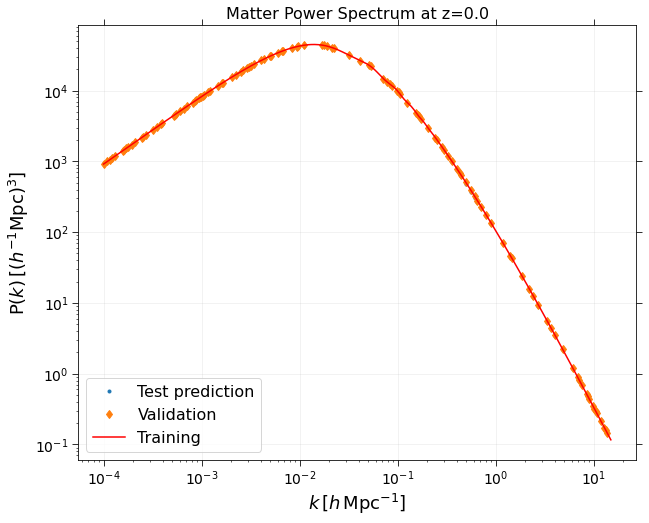

In [83]:
## TESTING (ANN for computing many cosmologies (for n_samples)):

# Generate power spectra:
cosmo_func = camb_cosmo(0)
    
train_k = cosmo_func[0]                                                             
train_pk = cosmo_func[1]    

# Standardising:

train_k_scaler = StandardScaler()
train_pk_scaler = StandardScaler()

# Storing the fit object for later reference
scaled_train_k = train_k_scaler.fit(np.log(train_k).reshape(-1,1)) 
scaled_train_pk = train_pk_scaler.fit(np.log(train_pk).reshape(-1,1))

# Generating the standardized values of X and y
X=scaled_train_k.transform(np.log(train_k).reshape(-1,1))
y=scaled_train_pk.transform(np.log(train_pk).reshape(-1,1))

# Split the data into training and testing set


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

# initializing the internal random number generator, setting random_state a fixed value will guarantee that
# same sequence of random numbers are generated each time you run the code.

# sort in ascending order:

zipped_lists = zip(X_train, y_train)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
X_train, y_train = [list(tuple) for tuple in  tuples]

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

#Building the NN:

tf_model = Sequential()
# Defining the first layer of the model
tf_model.add(Dense(units=32, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
tf_model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
tf_model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer='adam')
 
# Fitting the ANN to the Training set
tf_model.fit(X_train, y_train, batch_size = 20, epochs = 100, verbose=2)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
# printing the results of the current iteration
#print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
print('Accuracy:', 100-MAPE)


# Scaling the X data back to original scale
temp = X_train
temp2 = X_test

y_train_pred = scaled_train_pk.inverse_transform(tf_model.predict(temp))
y_test_pred = scaled_train_pk.inverse_transform(tf_model.predict(temp2))

X_train = scaled_train_k.inverse_transform(X_train)
X_test = scaled_train_k.inverse_transform(X_test)

# Scaling the y_test/train Price data back to original scale
y_train = scaled_train_pk.inverse_transform(y_train)
y_test = scaled_train_pk.inverse_transform(y_test)
    
# Scaling the test data back to original scale
#Test_Data = scaled_train_k.inverse_transform(X_test)

#Return to log scale:
X_train = np.exp(X_train)
y_train = np.exp(y_train)
X_test = np.exp(X_test)
y_test = np.exp(y_test)
prediction_train = np.exp(y_train_pred)
prediction_test = np.exp(y_test_pred)

plt.figure(figsize = (10,8))                                             ###DONE!
plt.loglog(X_test, prediction_test, "C0.")         #blue line
plt.loglog(X_test, y_test, "C1d")
plt.loglog(train_k, train_pk, 'r')
plt.title('Matter Power Spectrum at z=0.0')
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=16)
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
plt.legend(['Test prediction','Validation', 'Training'], loc='lower left', fontsize=16);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.show()

# #residual plot
# ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
# ax[1].loglog(train_k, ((prediction_train-train_pk)/train_pk), 'r', linestyle="dashdot")  #
# #plt.loglog(kh, pk[0], 'C0', linestyle="dashed")   
# #ax[1].loglog(kh, ((y_test-train_pk)/train_pk), 'C0')
# ax[1].set_yscale('linear')
# fig.tight_layout()
# plt.savefig('power_spectrum_H0.pdf')
# plt.show()

In [84]:
print(np.shape(train_k))
print(np.shape(train_pk))
print(np.shape(prediction_train))

(400,)
(400,)
(280, 1)


In [85]:
len(train_params['h'])

1400

In [86]:
## Training input params:
h = cosmo_params[:, 0]
# ombh2:
omega_b = cosmo_params[:, 1]
# omch2:
omega_c = cosmo_params[:, 2]

#Obtain pk matrix for output training param:
pk_matrix = []                                    #np.zeros((len(train_params['h']), np.shape(train_params)[0])) 
#print(pk_matrix[199][2])


%%time
for i in range(len(train_params['h'])):
               cosmo_func = camb_cosmo(i)
               pk_matrix.append(cosmo_func[1])

In [87]:
# np.shape(pk_matrix)                          #800x100: 800 cosmologies/n_samples, each with 100 pts/elements in array
# print(pk_matrix[199])

In [158]:
temp = pk_matrix

pk_mat_data = "pk_matrix.pkl"

open_file = open(pk_mat_data, "wb")
pickle.dump(pk_matrix, open_file)
open_file.close()

open_file = open(pk_mat_data, "rb")
pk_matrix = pickle.load(open_file)
open_file.close()

In [160]:
# Training input params and output param:

train_H0 = 100*h                               #1x400                     # np.arrays, sizes len(train_params['h'])
train_omega_b = omega_b                        #1x400
train_omega_c = omega_c                        #1x400
train_pk = pk_matrix                           #400x800                   # don't need kh, stays the same

In [161]:
input_params = np.vstack([train_H0, train_omega_b, train_omega_c])        # n_samples = no. of rows

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['H0', 'Omega_b', 'Omega_cdm']

output_data = pd.DataFrame(train_pk)                                       
print( input_data)                                                         #800x3
#print(output_data)

(1400, 3)
(1400, 400)
             H0   Omega_b  Omega_cdm
0     98.141530  0.017974   0.156076
1     55.182273  0.028939   0.097462
2     94.031451  0.033570   0.219550
3     81.022159  0.027909   0.072445
4     77.126519  0.021690   0.236991
...         ...       ...        ...
1395  96.068620  0.023249   0.192102
1396  88.384560  0.030540   0.148499
1397  61.579700  0.019260   0.157076
1398  75.196569  0.021576   0.214975
1399  69.335239  0.033642   0.191244

[1400 rows x 3 columns]


In [162]:
# Storing the fit object for later reference

# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=42)
print(np.shape(X_train))    # 350x3
print(X_train.shape[1])     # 3

(1120, 3)
3


In [163]:
print(X_train)

             H0   Omega_b  Omega_cdm
1121  99.535382  0.032784   0.219836
48    99.106505  0.030497   0.235561
155   54.360257  0.019174   0.160936
306   73.802716  0.023492   0.182094
1287  87.598284  0.021276   0.125482
...         ...       ...        ...
1095  69.406719  0.018174   0.239850
1130  82.416011  0.021147   0.134918
1294  70.514653  0.016401   0.181523
860   71.443888  0.021419   0.123767
1126  66.940672  0.018717   0.072873

[1120 rows x 3 columns]


In [164]:
# Standardising:

train_input_data = StandardScaler()
test_input_data = StandardScaler()

scaled_X_train = train_input_data.fit(X_train)
scaled_X_test = test_input_data.fit(X_test)

# # Generating the standardized values of X_train, X_test:
# X_train1 = scaled_X_train.transform(X_train)                  ##############3
# X_test1 = scaled_X_test.transform(X_test)                     #########3#####

X_train1 = X_train
X_test1 = X_test

In [165]:
print("y_test shape:", np.shape(y_test))
print("X_train1 shape:", np.shape(X_train1))
print("X_test1 shape:",np.shape(X_test1))
print("X_train:", X_train1)
print("X_test:", X_test1)

y_test shape: (280, 400)
X_train1 shape: (1120, 3)
X_test1 shape: (280, 3)
X_train:              H0   Omega_b  Omega_cdm
1121  99.535382  0.032784   0.219836
48    99.106505  0.030497   0.235561
155   54.360257  0.019174   0.160936
306   73.802716  0.023492   0.182094
1287  87.598284  0.021276   0.125482
...         ...       ...        ...
1095  69.406719  0.018174   0.239850
1130  82.416011  0.021147   0.134918
1294  70.514653  0.016401   0.181523
860   71.443888  0.021419   0.123767
1126  66.940672  0.018717   0.072873

[1120 rows x 3 columns]
X_test:              H0   Omega_b  Omega_cdm
665   80.235883  0.030654   0.207398
624   89.635454  0.034500   0.121909
115   55.611151  0.026408   0.146069
478   63.759828  0.028495   0.229414
233   69.263760  0.025836   0.184668
...         ...       ...        ...
188   86.704789  0.020304   0.186669
1091  97.819871  0.026422   0.166798
377   91.636883  0.018188   0.165797
351   60.721944  0.024964   0.115618
415   83.416726  0.023134   0.08

In [173]:
#Building the NN:

tf_model = Sequential()
# Defining the first layer of the model
tf_model.add(Dense(units=32, input_dim=X_train1.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
tf_model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
 
# Defining the Third layer of the model
tf_model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))

# Defining the fourth layer of the model
#tf_model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))    

# The output neuron is a single fully connected node 
# Since we will be predicting a single number
tf_model.add(Dense(400, kernel_initializer='normal'))
 
opt = keras.optimizers.Adam(learning_rate=0.1)
    
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer=opt)
 
# Fitting the ANN to the Training set
tf_model.fit(X_train1, y_train, batch_size = 25, epochs = 200, verbose=2)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test1))/y_test))*100
# printing the results of the current iteration
#print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
print(np.shape(100-MAPE))
#print('Accuracy:', 100-MAPE)

Epoch 1/200
45/45 - 0s - loss: 43012760.0000 - 315ms/epoch - 7ms/step
Epoch 2/200
45/45 - 0s - loss: 19592430.0000 - 57ms/epoch - 1ms/step
Epoch 3/200
45/45 - 0s - loss: 18607924.0000 - 46ms/epoch - 1ms/step
Epoch 4/200
45/45 - 0s - loss: 17943284.0000 - 46ms/epoch - 1ms/step
Epoch 5/200
45/45 - 0s - loss: 15982954.0000 - 46ms/epoch - 1ms/step
Epoch 6/200
45/45 - 0s - loss: 13088169.0000 - 49ms/epoch - 1ms/step
Epoch 7/200
45/45 - 0s - loss: 12685185.0000 - 47ms/epoch - 1ms/step
Epoch 8/200
45/45 - 0s - loss: 12486629.0000 - 51ms/epoch - 1ms/step
Epoch 9/200
45/45 - 0s - loss: 12430086.0000 - 48ms/epoch - 1ms/step
Epoch 10/200
45/45 - 0s - loss: 12404770.0000 - 45ms/epoch - 997us/step
Epoch 11/200
45/45 - 0s - loss: 10719801.0000 - 47ms/epoch - 1ms/step
Epoch 12/200
45/45 - 0s - loss: 10366295.0000 - 43ms/epoch - 965us/step
Epoch 13/200
45/45 - 0s - loss: 10709351.0000 - 39ms/epoch - 875us/step
Epoch 14/200
45/45 - 0s - loss: 10212980.0000 - 44ms/epoch - 975us/step
Epoch 15/200
45/45 -

45/45 - 0s - loss: 4419639.5000 - 43ms/epoch - 953us/step
Epoch 118/200
45/45 - 0s - loss: 1235724.5000 - 41ms/epoch - 909us/step
Epoch 119/200
45/45 - 0s - loss: 720834.5000 - 41ms/epoch - 909us/step
Epoch 120/200
45/45 - 0s - loss: 581462.8125 - 40ms/epoch - 887us/step
Epoch 121/200
45/45 - 0s - loss: 1650125.0000 - 41ms/epoch - 909us/step
Epoch 122/200
45/45 - 0s - loss: 760562.8750 - 40ms/epoch - 887us/step
Epoch 123/200
45/45 - 0s - loss: 763340.5625 - 40ms/epoch - 887us/step
Epoch 124/200
45/45 - 0s - loss: 687350.3125 - 41ms/epoch - 909us/step
Epoch 125/200
45/45 - 0s - loss: 1679021.5000 - 40ms/epoch - 887us/step
Epoch 126/200
45/45 - 0s - loss: 1012086.5000 - 40ms/epoch - 887us/step
Epoch 127/200
45/45 - 0s - loss: 644812.7500 - 41ms/epoch - 909us/step
Epoch 128/200
45/45 - 0s - loss: 499310.0000 - 41ms/epoch - 909us/step
Epoch 129/200
45/45 - 0s - loss: 1573609.8750 - 40ms/epoch - 887us/step
Epoch 130/200
45/45 - 0s - loss: 848461.2500 - 43ms/epoch - 953us/step
Epoch 131/200


c:\program files\python39\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [174]:
# Scaling the X data back to original scale

#temp = X_train1
#temp2 = X_test1

y_train_pred = tf_model.predict(X_train1)
y_test_pred = tf_model.predict(X_test1)

# X_train2 = scaled_X_train.inverse_transform(X_train1)     ###########3
# X_test2 = scaled_X_train.inverse_transform(X_test1)       ########33##


# Prediction:
prediction_train = y_train_pred
prediction_test = y_test_pred


print(np.shape(X_train2))
print(np.shape(X_train2[0]))                                             #OK, RESHAPE TO (1,3) for tf_model.predict()
print(X_train2[0])
a = np.reshape(X_train2[0], (1,3))
print(np.shape(a))
a = tf_model.predict(a)

(1190, 3)
(3,)
[8.98498928e+01 2.45639743e-02 1.65654039e-01]
(1, 3)


H0, Omega_b, Omega_cdm: 67.5 0.02 0.122


parameters:  ['67.5', '0.02', '0.122']


H0: 67.5 Omega_b: 0.02 Omega_c: 0.122


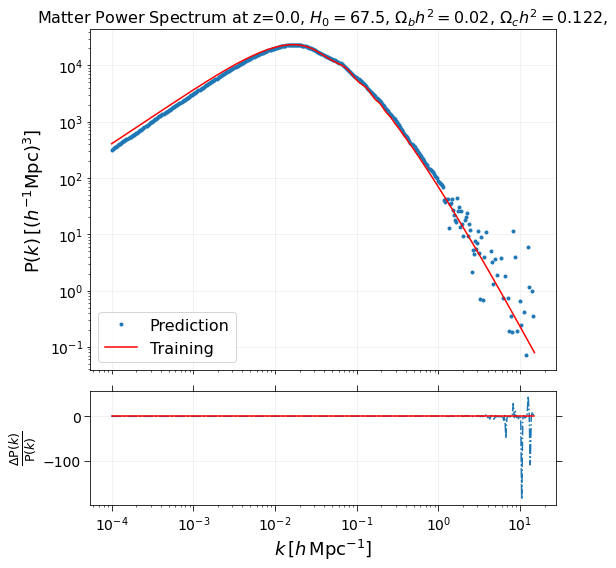

In [175]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input('H0, Omega_b, Omega_cdm: ')
    print("\n")
    user_list = input_cosmo_val.split()
    # print list
    print('parameters: ', user_list)

    # convert each item to int type
    for i in range(len(user_list)):
        # convert each item to int type
        user_list[i] = float(user_list[i])
        
    
    cosmo_arr = np.reshape(np.array(user_list),(1, 3))
    pred_pk = tf_model.predict(cosmo_arr)
    
    def camb_cosmo2():
    
        #Compute P.S via CAMB:
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=cosmo_arr[0][1], omch2=cosmo_arr[0][2])
        pars.InitPower.set_params(As = 2e-9, ns=0.965)
        pars.set_matter_power(redshifts=[0.0], kmax=10.0)
        pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

        # Linear spectra
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        camb_kh, z, camb_pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=400)
        s8 = np.array(results.get_sigma8())
    
        return camb_kh, camb_pk[0] 
    
    generate_camb_ps = camb_cosmo2()
#     temp = generate_camb_ps

    print('H0:' , cosmo_arr[0][0], 'Omega_b:', cosmo_arr[0][1], 'Omega_c:', cosmo_arr[0][2])
    #print(pred_pk)
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (8,8), gridspec_kw={'height_ratios': [3, 1]})                                            
    ax[0].loglog(generate_camb_ps[0], pred_pk[0], "C0.")                                    
    #plt.loglog(X_test, y_test, "C1d")
    ax[0].loglog(generate_camb_ps[0], generate_camb_ps[1], 'r')                              
    ax[0].set_title('Matter Power Spectrum at z=0.0, $H_{0} = %0.5s$, ' %cosmo_arr[0][0] + '$\Omega_{b}h^{2} = %0.6s$, ' %cosmo_arr[0][1] + '$\Omega_{c}h^{2} = %0.6s$, ' %cosmo_arr[0][2])
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(['Prediction', 'Training'], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    
#     #pred_pk needs to be sorted:
#     zipped_lists = zip(temp, pred_pk)
#     sorted_pairs = sorted(zipped_lists)

#     tuples = zip(*sorted_pairs)
#     temp, pred_pk = [list(tuple) for tuple in  tuples]
#     temp = np.array(temp)
#     pred_pk = np.array(pred_pk)
    
    #residual plot 
    ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
    ax[1].loglog(generate_camb_ps[0], ((pred_pk[0]-generate_camb_ps[1])/generate_camb_ps[1]), 'C0', linestyle="dashdot") 
    ax[1].loglog(generate_camb_ps[0], ((generate_camb_ps[1]-generate_camb_ps[1])/generate_camb_ps[1]), 'r')
    ax[1].set_yscale('linear')
    fig.tight_layout()
    #plt.savefig('power_spectrum_H0.pdf')
    plt.show()
    
    

Generate = calc_cosmo()